# Landcover Evaluation Results

## Initialisation

In [1]:
import json
import numpy as np
import os
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from matplotlib.legend import Legend
from matplotlib.container import BarContainer

import initialise
import common
from analysis_utils import calc_statistics
from display_utils import display_frames

In [2]:
%matplotlib inline

In [3]:
samples_file = os.path.join(common.DATASETS_DIR, 'samples_730days.csv')
model_dir = os.path.join(common.MODELS_DIR, 'evaluation_models', 'test3')

In [4]:
MODEL_RMSE = 27.52
MODEL_R2 = 0.47
TEXT_SIZE = 7
FONT_SIZE = 7
TITLE_SIZE = 8
MARKER_SIZE = 7
LINE_WIDTH = 0.75
LINE_ALPHA = 0.75
SATURATION = 0.6

### Load Samples and Predictions

In [5]:
with open(os.path.join(model_dir, 'model_params.json'), 'r') as f:
    ws_params = json.load(f)
all_samples = pd.read_csv(samples_file, index_col=0)
predict = pd.read_csv(os.path.join(model_dir, f'ensemble{common.ENSEMBLE_SIZE}_{common.ANALYSIS_MODEL}.csv'), index_col=0)
samples = all_samples.reindex(predict.index)

### Create Land Cover groups

In [6]:
land_cover = sorted(samples['Land Cover'].unique())

landcover_groups = {
    'Agriculture': [0, 3, 5],
    'Forest': [6, 9, 11, 12, 13, 14],
    'Grassland': [1, 2, 4],
    'Shrubland': [7],
    'Other': [8, 10, 15, 16],
}
lc_labels = list(landcover_groups.keys())

lc_summary = samples.groupby(['Land Cover', 'Site'], as_index=False).size().groupby(['Land Cover']).agg({'size': 'sum', "Site": "count"})
lc_summary['landcover_group'] = ''
for group, classes in landcover_groups.items():
    lc = [land_cover[c] for c in classes]
    lc_summary.loc[lc, 'landcover_group'] = group
lc_summary = lc_summary.reset_index()
lc_summary.columns = ['Land Cover', '#Samples', '#Sites', 'Category']
lc_summary[['Category', 'Land Cover', '#Samples', '#Sites']].sort_values(['Category', 'Land Cover'])

,Category,Land Cover,#Samples,#Sites
0,Agriculture,"Cropland, rainfed",356,9
3,Agriculture,Mosaic cropland (>50%) / natural vegetation (t...,179,6
5,Agriculture,"Mosaic natural vegetation (tree, shrub, herbac...",108,4
6,Forest,Mosaic tree and shrub (>50%) / herbaceous cove...,164,2
9,Forest,"Tree cover, broadleaved, deciduous, closed to ...",395,20
11,Forest,"Tree cover, mixed leaf type (broadleaved and n...",697,22
12,Forest,"Tree cover, needleleaved, deciduous, closed to...",96,3
13,Forest,"Tree cover, needleleaved, evergreen, closed (>...",442,23
14,Forest,"Tree cover, needleleaved, evergreen, closed to...",10094,420
1,Grassland,Grassland,1465,44


### Create Elevation Groups

In [7]:
upper = 6000
elevation_groups = {
    '> 2000m': [2000/upper, 6000/upper],
    '1500-2000m': [1500/upper, 2000/upper],
    '1000-1500m': [1000/upper, 1500/upper],
    '500-1000m': [500/upper, 1000/upper],
    '< 500m': [0/upper, 500/upper],
}
el_labels = list(elevation_groups.keys())

elevation_summ = []
for label, heights in elevation_groups.items():
    hdf = samples[(samples.Elevation.between(heights[0], heights[1]))]
    sdf = hdf[['Site', 'Land Cover', 'Czone3']].drop_duplicates()
    samples_ = hdf.Elevation.size
    sites_ = sdf.Site.size  #hdf.Site.unique().size
    lc = sdf['Land Cover'].mode()
    cz = sdf['Czone3'].mode()
    elevation_summ.append({'Elevation': label, '#Samples': samples_, '#Sites': sites_, 'Land Cover': lc[0], 'Climate Zone': cz[0]})
pd.DataFrame(elevation_summ)

,Elevation,#Samples,#Sites,Land Cover,Climate Zone
0,> 2000m,5801,286,"Tree cover, needleleaved, evergreen, closed to...",BSk
1,1500-2000m,4437,177,"Tree cover, needleleaved, evergreen, closed to...",BSk
2,1000-1500m,3579,132,"Tree cover, needleleaved, evergreen, closed to...",BSk
3,500-1000m,3573,98,Shrubland,Csa
4,< 500m,4130,106,"Tree cover, needleleaved, evergreen, closed to...",Cfa


## Analysis
### Analysis by Land Cover

In [8]:
def landcover_results(samples, predictions):
    lc_predicts = []
    lc_tests = []
    lc_samples = []
    lc_y = []
    for group, classes in landcover_groups.items():
        lc = [land_cover[c] for c in classes]
        y = samples[samples['Land Cover'].isin(lc)]['LFMC value']
        z = predictions[samples['Land Cover'].isin(lc)].reindex(y.index)
        if z.shape[0] >= 10:
            lc_y.append(y)
            lc_predicts.append(z)
            lc_tests.append(group)
            lc_samples.append(y.count())

    lc_results = pd.DataFrame(lc_samples, columns=['Samples'], index=lc_tests).rename_axis(['Land Cover'])

    lc_stats = []
    for i, pred_ in enumerate(lc_predicts):
        e = {}
        for model_ in pred_.columns:
            e[model_] = calc_statistics(lc_y[i], pred_[model_], ybar=samples['LFMC value'].mean())
            e[model_]['Samples'] = lc_samples[i] #pred_.shape[0]
        lc_stats.append(pd.DataFrame.from_dict(e, orient='index'))

    edf = pd.DataFrame.from_dict({lc_tests[n]: e.mean() for n, e in enumerate(lc_stats)}, orient='index').convert_dtypes()
    sdf = pd.DataFrame.from_dict({lc_tests[n]: e.std() for n, e in enumerate(lc_stats)}, orient='index').convert_dtypes()
    lc_results['Mean LFMC'] = [y.mean() for y in lc_y]
    lc_results['Variance'] = [y.var() for y in lc_y]
    lc_results['Bias'] = list(edf.Bias)
    lc_results['RMSE'] = list(edf.RMSE)
    lc_results['R2'] = list(edf.R2)
    lc_results['Bias_std'] = list(sdf.Bias)
    lc_results['RMSE_std'] = list(sdf.RMSE)
    lc_results['R2_std'] = list(sdf.R2)
    
    vars_ = list(landcover_groups.keys())
    bp_data = []
    for n, t in enumerate(lc_results.index):
        if t in vars_:
            d = {p_[0]: pd.concat([p_[1], lc_y[n], p_[1] - lc_y[n]], keys=['Estimated LFMC', 'LFMC value', 'Error'], axis=1) for p_ in lc_predicts[n].iteritems()}
            for m, df_ in d.items():
                df_['Model'] = m
            d = pd.concat(d.values())
            d['Land cover'] = t
            bp_data.append(d)
    bp_data = pd.concat(bp_data)
    
    return bp_data, lc_results


In [9]:
heading = f'Results by Landcover'
print('=' * len(heading))
print(heading)
print('=' * len(heading))

lc1_plot_data, lc1_results = landcover_results(samples, predict)
lc1_results

Results by Landcover


,Samples,Mean LFMC,Variance,Bias,RMSE,R2,Bias_std,RMSE_std,R2_std
Land Cover,,,,,,,,,
Agriculture,643,111.191213,1971.446534,-2.2778,29.0882,0.5718,0.242818,0.168374,0.005956
Forest,11888,108.809369,1117.028412,1.6410,27.2110,0.3392,0.120767,0.034241,0.002740
Grassland,1556,106.462350,1501.143451,7.6058,28.0952,0.4756,0.161575,0.111250,0.005014
Shrubland,7281,107.525443,1869.256145,0.1436,27.7944,0.5882,0.128154,0.073267,0.003881
Other,152,130.145833,651.929383,-7.3690,25.6110,0.4144,0.630317,0.329032,0.015274


### Analysis by Land Cover and Elevation

In [10]:
def landcover_elevation_results(samples, predictions):
    lc_y = []
    lc_predicts = []
    lc_tests = []
    lc_samples = []
    for group, classes in landcover_groups.items():
        lc = [land_cover[c] for c in classes]
        for label, heights in elevation_groups.items():
            ind = (samples['Land Cover'].isin(lc)) & (samples.Elevation.between(heights[0], heights[1]))
            y = samples[ind]['LFMC value']
            z = predictions[ind].reindex(y.index)
            if z.shape[0] >= 10:
                lc_y.append(y)
                lc_predicts.append(z)
                lc_tests.append([group, label])
                lc_samples.append(y.count())

    lc_results = pd.DataFrame(lc_samples, columns=['Samples'], index=[[t[0] for t in lc_tests], [t[1] for t in lc_tests]])
    lc_results = lc_results.rename_axis(['Land Cover', 'Elevation'])

    lc_stats = []
    for i, pred_ in enumerate(lc_predicts):
        e = {}
        for model_ in pred_.columns:
            e[model_] = calc_statistics(lc_y[i], pred_[model_], ybar=samples['LFMC value'].mean())
            e[model_]['Samples'] = lc_samples[i]
        lc_stats.append(pd.DataFrame.from_dict(e, orient='index'))
        
    edf = pd.DataFrame.from_dict({';'.join(lc_tests[n]): e.mean() for n, e in enumerate(lc_stats)}, orient='index').convert_dtypes()
    sdf = pd.DataFrame.from_dict({';'.join(lc_tests[n]): e.std() for n, e in enumerate(lc_stats)}, orient='index').convert_dtypes()
    lc_results['Mean LFMC'] = [y.mean() for y in lc_y]
    lc_results['Variance'] = [y.var() for y in lc_y]
    lc_results['Bias'] = list(edf.Bias)
    lc_results['RMSE'] = list(edf.RMSE)
#    lc_results['ubRMSE'] = list(edf.ubRMSE)
    lc_results['R2'] = list(edf.R2)
    lc_results['Bias_std'] = list(sdf.Bias)
    lc_results['RMSE_std'] = list(sdf.RMSE)
#    lc_results['ubRMSE_std'] = list(sdf.ubRMSE)
    lc_results['R2_std'] = list(sdf.R2)

    labels = list(elevation_groups.keys())
    vars_ = list(landcover_groups.keys())[1:-1]
    bp_data = []
    for n, t in enumerate(lc_tests):
        if t[0] in vars_ and t[1] in labels:
            d = [pd.concat([p_[1], lc_y[n], p_[1] - lc_y[n]], keys=['Estimated LFMC', 'LFMC value', 'Error'], axis=1) for p_ in lc_predicts[n].iteritems()]
            d = pd.concat(d)
            d['Land cover'] = t[0]
            d['Elevation'] = t[1]
            bp_data.append(d)
    bp_data = pd.concat(bp_data)
    
    return bp_data, lc_results

In [11]:
heading = f'Results by Landcover and Elevation'
print('=' * len(heading))
print(heading)
print('=' * len(heading))

lc3_plot_data, lc3_results = landcover_elevation_results(samples, predict)
lc3_results

Results by Landcover and Elevation


Samples   Mean LFMC     Variance     Bias     RMSE  \
Land Cover  Elevation                                                        
Agriculture > 2000m          19  131.179824   773.229377  21.2550  29.8578   
            1500-2000m       50  129.286666  1545.561250  -4.3334  30.4594   
            1000-1500m      223  101.202541  1831.452293  -0.7236  22.8332   
            500-1000m        74  117.432432  1566.789893  -3.4662  23.4408   
            < 500m          277  112.927918  2192.495902  -4.4548  34.1842   
Forest      > 2000m        4552  112.440220   799.530113  -0.1976  26.3754   
            1500-2000m     1998  112.678343  1106.578590   1.3356  26.7330   
            1000-1500m     1788  111.864681  1745.296923  -0.2222  33.7568   
            500-1000m      1659   90.806259   988.747374   5.7492  21.5924   
            < 500m         1891  108.886797  1072.543742   4.5474  27.1808   
Grassland   > 2000m          53  106.770440   782.255324  -1.9008  18.9366   
            1500-2000m      167  110.661178  1547.944873   4.0522  23.0886   
            1000-1500m      395   95.582700  1783.071968   8.5390  32.1986   
            500-1000m       152  125.518640  2820.556122  -1.5136  32.9398   
            < 500m          789  107.328475  1018.672547  10.2854  26.2992   
Shrubland   > 2000m        1177  116.049602  1428.531573  -1.7286  27.1472   
            1500-2000m     2196  115.799218  1788.159421  -3.0492  27.9256   
            1000-1500m     1173  111.423487  2354.922959  -0.8450  27.8584   
            500-1000m      1688   97.720922  1631.042531   5.3710  25.1336   
            < 500m         1047   92.029242  1744.097432   1.6236  31.9414   
Other       1500-2000m       26  121.326923   431.458846  12.2518  24.3930   
            < 500m          126  131.965608   681.724030 -11.4182  25.8538   

                            R2  Bias_std  RMSE_std    R2_std  
Land Cover  Elevation                                         
Agriculture > 2000m     0.2864  1.279573  0.896388  0.042703  
            1500-2000m  0.5250  0.595451  0.474649  0.015419  
            1000-1500m  0.7218  0.266188  0.298974  0.007743  
            500-1000m   0.6616  0.546857  0.321621  0.010373  
            < 500m      0.4694  0.428177  0.375821  0.011851  
Forest      > 2000m     0.1480  0.176723  0.039960  0.004041  
            1500-2000m  0.3632  0.157935  0.074512  0.005127  
            1000-1500m  0.3510  0.162898  0.128006  0.005803  
            500-1000m   0.6408  0.219041  0.132412  0.005284  
            < 500m      0.3102  0.299270  0.140303  0.007690  
Grassland   > 2000m     0.5344  0.347380  0.291594  0.014730  
            1500-2000m  0.6544  0.316107  0.237624  0.007329  
            1000-1500m  0.4668  0.183250  0.133554  0.005127  
            500-1000m   0.6494  0.398240  0.277500  0.006197  
            < 500m      0.3208  0.252508  0.162617  0.009223  
Shrubland   > 2000m     0.5040  0.191044  0.103806  0.004949  
            1500-2000m  0.5774  0.186983  0.104611  0.004431  
            1000-1500m  0.6712  0.160245  0.156575  0.004352  
            500-1000m   0.6382  0.203000  0.127019  0.003881  
            < 500m      0.4926  0.275235  0.124851  0.004431  
Other       1500-2000m -0.0238  0.730775  0.615793  0.051898  
            < 500m      0.4562  0.742549  0.353518  0.015635

#### Elevation distributions
Show the proportion of each class at each elevation

In [12]:
dist1 = (lc3_results.Samples.unstack().T / lc3_results.Samples.unstack().sum(axis=1) * 100).round().loc[el_labels]
dist1

Land Cover,Agriculture,Forest,Grassland,Other,Shrubland
Elevation,,,,,
> 2000m,3.0,38.0,3.0,NaN,16.0
1500-2000m,8.0,17.0,11.0,17.0,30.0
1000-1500m,35.0,15.0,25.0,NaN,16.0
500-1000m,12.0,14.0,10.0,NaN,23.0
< 500m,43.0,16.0,51.0,83.0,14.0


## Generate Figures
### Landcover and Elevation Figure

In [13]:
def get_whiskers(data, plot, group=['Land cover']):
    whiskers = data.groupby(group)[plot].describe()[['25%', '75%']]
    whiskers['iqr'] = whiskers.diff(axis=1)['75%']
    whiskers['lower'] = whiskers['25%'] - 1.5 * whiskers['iqr']
    whiskers['upper'] = whiskers['75%'] + 1.5 * whiskers['iqr']
    return whiskers

In [14]:
def samples_plot_lc(data, summ, ax, xlim):
    sns.boxplot(y='Land cover', x='LFMC value', data=data, #order=plot_order, palette=czones,
                saturation=SATURATION, width=0.8, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2, 'lw': LINE_WIDTH}, whiskerprops={'zorder': 2})
    ax.set_ylabel('Land cover', fontsize=FONT_SIZE)
    ax.set_xlabel(None)

    whiskers = get_whiskers(data, 'LFMC value').loc[summ.index]
    minimums = data.groupby(['Land cover']).min().loc[summ.index]['LFMC value']

    for ytick in ax.get_yticks():
        c = summ.loc[lc_labels[ytick]]
        va = 'center' if (minimums.iloc[ytick] > 35) or (whiskers.iloc[ytick]['lower'] > 35) else 'bottom'
        ax.text(2, ytick, c, va=va, size=TEXT_SIZE, zorder=3)
  
    ylim = ax.get_ylim()
    ax.text(2, ylim[1], 'Samples', va='bottom', size=TEXT_SIZE)
    xline = samples['LFMC value'].mean()
    ax.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, alpha=LINE_ALPHA, zorder=1)

    ax.set_xlim(xlim)
    ax.set_xticks(range(xlim[0], xlim[1]+10, 50))
    ax.tick_params(labelsize=TEXT_SIZE)

    return ax, ylim

In [15]:
def plot_landcover(bp_data, lc_results, ax, xlim, xline, ylim, label):
    r1 = lc_results.reset_index()
    r1 = r1[r1['Land Cover'].isin(lc_labels)]
    r1 = r1.set_index(['Land Cover'])

    sns.boxplot(y='Land cover', x='Error', data=bp_data,
                saturation=SATURATION, width=0.8, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2}, whiskerprops={'zorder': 2})

    bias = bp_data.groupby(['Land cover']).Error.mean().round(2)
    whiskers = get_whiskers(bp_data, 'Error').loc[lc_results.index]
    for ytick in ax.get_yticks():
        rmse = r1.RMSE.loc[lc_labels[ytick]]
        rmse_std = r1.RMSE_std.loc[lc_labels[ytick]]
        n_samples = r1.Samples.loc[lc_labels[ytick]]
        bias_ = bias.loc[lc_labels[ytick]]

        # Add the bias text
        va = 'bottom' if whiskers.loc[lc_labels[ytick]]['lower'] < -55 else 'center'
        t = ax.text(xlim[0]+1, ytick, f'{bias_: .2f}', ha='left', va=va, color='k', size=7)

        # Add the RMSE marker
        pt, = ax.plot(rmse, ytick, 'dk', markersize=7, scalex=False, zorder=3, mew=LINE_WIDTH,
                      mfc=plt.rcParams["axes.prop_cycle"].by_key()["color"][ytick])

        pos_ = round(rmse, 2) + 3
        rmse_text = f'{rmse:.2f}'
        t = ax.text(pos_, ytick, rmse_text, va='bottom', color='k', size=TEXT_SIZE)
            
    ax.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, alpha=LINE_ALPHA, zorder=1)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xlim(xlim)
    ax.set_xticks(range(-50, 71, 25))
    ax.text(xlim[0]+1, ylim[1], 'Bias (%)', va='bottom', size=TEXT_SIZE)
    return ax

In [16]:
def plot_landcover_r2(bp_data, lc_results, ax, xlim, xline_pred, xline_r2, ylim, xlim_r2, label):
    r1 = lc_results.reset_index()
    r1 = r1[r1['Land Cover'].isin(lc_labels)]
    r1 = r1.set_index(['Land Cover'])

    ax.plot([xline_pred, xline_pred], ylim, '--', color='grey', linewidth=LINE_WIDTH, alpha=LINE_ALPHA, zorder=1)
    sns.boxplot(y='Land cover', x='Estimated LFMC', data=bp_data,
                saturation=SATURATION, width=0.8, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2}, whiskerprops={'zorder': 2})
    ax.set_xlim(xlim)
    ax.set_xticks(range(xlim[0], xlim[1]+1, 40))
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    ax1=ax.twiny()
    ax1.set_xlim([0, 1])
    plt.setp(ax1.get_xticklabels(), color="blue")
    ax1.plot([xline_r2, xline_r2], ylim, ':', color='blue', linewidth=LINE_WIDTH, alpha=LINE_ALPHA, zorder=-1)

    for ytick in ax.get_yticks():
        r2 = r1.R2.loc[lc_labels[ytick]]
        r2_std = r1.R2_std.loc[lc_labels[ytick]]

        # Add the R2 marker
        pt, = ax1.plot(r2, ytick, '*k', markersize=9, scalex=False, mew=LINE_WIDTH, mec='blue', 
                      mfc=plt.rcParams["axes.prop_cycle"].by_key()["color"][ytick])

        # Add the R2 text
        pos_ = round(r2, 2)
        r2_text = f'{r2:.2f}' #'\n$\pm${r2_std:.2f}' 
        ha = 'right' if r2 < 0.45 else 'left'
        pos_ = (pos_ - 0.04) if r2 < 0.45 else (pos_ + 0.03)
        t = ax1.text(pos_, ytick, r2_text, va='bottom', ha=ha, color='b', size=7)

    ax1.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax1.set_xticklabels(['$R^2$', 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=FONT_SIZE)
    line = ax1.get_children()[0]
    line.remove()
    ax.add_artist(line)
    return ax, ax1

In [17]:
def samples_plot_el(data, summ, ax, xlim):
    sns.boxplot(y='Elevation', x='LFMC value', hue='Land cover', data=data, #order=plot_order, palette=czones,
                saturation=SATURATION, width=0.8, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2, 'lw': LINE_WIDTH}, whiskerprops={'zorder': 2})
    ax.set_ylabel('Elevation', fontsize=FONT_SIZE)
    ax.set_xlabel(f'Measured LFMC (%)', fontsize=FONT_SIZE)

    index_ = summ[vars_].index.swaplevel()
    whiskers = get_whiskers(data, 'LFMC value', ['Elevation', 'Land cover']).loc[index_]
    minimums = data.groupby(['Elevation', 'Land cover']).min().loc[index_]['LFMC value']
    ng = len(vars_)
    for ytick in ax.get_yticks():
        for lc in range(ng):
            c = summ.loc[vars_[lc], labels[ytick]]
            va = 'center' if ((minimums.loc[labels[ytick], vars_[lc]] > 35)
                              or (whiskers.loc[labels[ytick], vars_[lc]]['lower'] > 35)
                 ) else 'bottom'
            y_off = ytick + [-0.267, 0.0, .267][lc]
            ax.text(2, y_off, c, va=va, size=TEXT_SIZE, zorder=3)

    ax.set_xlim(xlim)
    ax.set_xticks(range(xlim[0], xlim[1]+1, 50))
    ax.tick_params(labelsize=TEXT_SIZE)

    ylim = ax.get_ylim()
    xline = samples['LFMC value'].mean()
    ax.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, alpha=LINE_ALPHA, zorder=1)

    return ax, ylim

In [18]:
def plot_landcover_elevation(bp_data, lc_results, ax, xlim, xline, ylim, label):
    r1 = lc_results.reset_index()
    r1 = r1[r1.Elevation.isin(labels) & r1['Land Cover'].isin(vars_)]
    r1 = r1.set_index(['Elevation', 'Land Cover'])

    sns.boxplot(y='Elevation', x='Error', hue='Land cover', data=bp_data, order=labels,
                saturation=SATURATION, width=0.8, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2}, whiskerprops={'zorder': 2})

    bias = bp_data.groupby(['Elevation', 'Land cover']).Error.mean().round(2)
    whiskers = get_whiskers(bp_data, 'Error', ['Land cover', 'Elevation']).loc[lc_results.loc[vars_].index]
    ng = len(vars_)
    ne = len(labels)
    need_legend = True
    legend_points = []
    for ytick in ax.get_yticks():
        for lc in range(ng):
            y_off = ytick + [-0.267, 0.0, .267][lc]
            rmse = r1.RMSE.loc[labels[ytick], vars_[lc]]
            rmse_std = r1.RMSE_std.loc[labels[ytick], vars_[lc]]
            n_samples = r1.Samples.loc[labels[ytick], vars_[lc]]
            bias_ = bias.loc[labels[ytick], vars_[lc]]
            
            # Add the bias text
            va = 'center' if (whiskers.loc[vars_[lc], labels[ytick]]['lower'] > -53
                             ) else 'bottom'
            t = ax.text(xlim[0]+1, y_off, f'{bias_: .2f}', ha='left', va=va, color='k', size=7)
            
            # Add the RMSE marker
            pt, = ax.plot(rmse, y_off, 'dk', markersize=7, scalex=False, zorder=3, mew=LINE_WIDTH,
                          mfc=plt.rcParams["axes.prop_cycle"].by_key()["color"][lc])
            
            pos_ = round(rmse, 2) + 3
            rmse_text = f'{rmse:.2f}'
            t = ax.text(pos_, y_off, rmse_text, va='bottom', color='k', size=7)
            
    ax.plot([xline, xline], ylim, '--', color='grey', linewidth=LINE_WIDTH, alpha=LINE_ALPHA, zorder=1)
    ax.set_ylabel(None)
    ax.set_xlabel(f'Estimation Error Distribution,\nRMSE and Bias (%)', fontsize=FONT_SIZE)
    ax.set_xlim(xlim)
    ax.set_xticks(range(-50, 71, 25))
    return ax, legend_points

In [19]:
def plot_landcover_elevation_r2(bp_data, lc_results, ax, xlim, xline_pred, xline_r2, ylim, xlim_r2, label):
    r1 = lc_results.reset_index()
    r1 = r1[r1.Elevation.isin(labels) & r1['Land Cover'].isin(vars_)]
    r1 = r1.set_index(['Elevation', 'Land Cover'])

    ax.plot([xline_pred, xline_pred], ylim, '--', color='grey', linewidth=LINE_WIDTH, alpha=LINE_ALPHA, zorder=1)
    sns.boxplot(y='Elevation', x='Estimated LFMC', hue='Land cover', data=bp_data, order=labels,
                saturation=SATURATION, width=0.8, linewidth=LINE_WIDTH, showfliers=False, showcaps=False,
                ax=ax, zorder=2, boxprops={'zorder': 2}, whiskerprops={'zorder': 2})
    ax.set_xlabel(f'LFMC Estimation Distribution (%) and $R^2$', fontsize=FONT_SIZE)
    ax.set_xlim(xlim)
    ax.set_xticks(range(40, xlim[1]+1, 40))
    ax.set_ylabel(None)

    ax1=ax.twiny()
    ax1.set_xlim([0, 1])
    plt.setp(ax1.get_xticklabels(), color="blue")
    ax1.plot([xline_r2, xline_r2], ylim, ':', color='blue', linewidth=LINE_WIDTH, alpha=LINE_ALPHA, zorder=-1)

    ng = len(vars_)
    ne = len(labels)
    need_legend = True
    legend_points = []
    for ytick in ax.get_yticks():
        for lc in range(ng):
            y_off = ytick + [-0.267, 0.0, .267][lc]
            r2 = r1.R2.loc[labels[ytick], vars_[lc]]
            r2_std = r1.R2_std.loc[labels[ytick], vars_[lc]]
            
            # Add the R2 marker
            pt, = ax1.plot(r2, y_off, '*k', markersize=9, scalex=False, mew=LINE_WIDTH, mec='blue', 
                          mfc=plt.rcParams["axes.prop_cycle"].by_key()["color"][lc])
            
            # Add the R2 text
            pos_ = round(r2, 2)
            r2_text = f'{r2:.2f}' #'\n$\pm${r2_std:.2f}' 
            ha = 'right' if r2 < 0.4 else 'left'
            pos_ = ((pos_ - 0.03) if r2 < 0.33
                    else (pos_ - 0.07) if r2 < 0.36
                    else (pos_ - 0.04) if r2 < 0.4
                    else (pos_ + 0.03))
            t = ax1.text(pos_, y_off, r2_text, va='bottom', ha=ha, color='b', size=7)

    ax1.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax1.set_xticklabels([])
    line = ax1.get_children()[0]
    line.remove()
    ax.add_artist(line)

    return ax, ax1 #legend_points

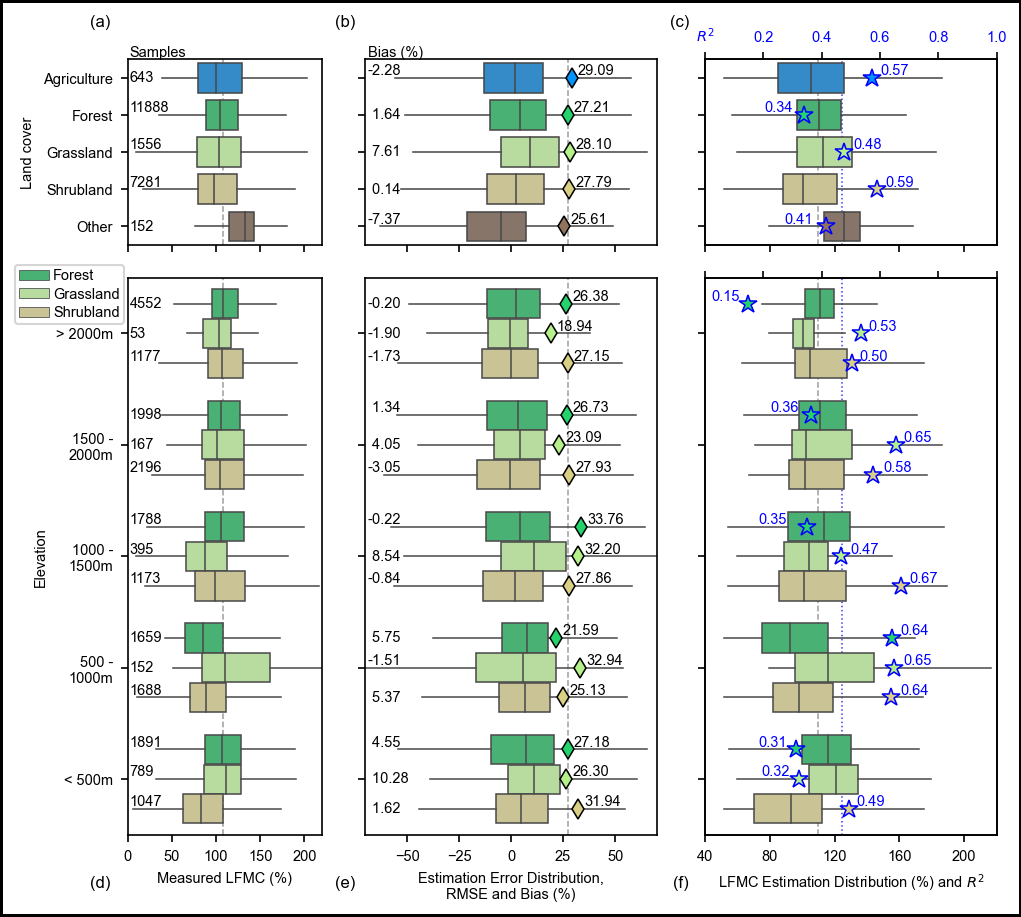

In [20]:
mean_pred = predict.mean().mean()

plt.rcParams.update({'font.sans-serif': 'Arial'})
plt.rcParams.update({'font.size': TEXT_SIZE})

xlim_lfmc = (0, 220)
xlim_rmse = (-70, 70)
xlim_r2 = (-0.1, 0.85)
xlim_pred = (40, 220)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    2, 3, figsize=(6.7, 6), gridspec_kw={'width_ratios': [2, 3, 3], 'height_ratios': [1, 3]},
    sharey='row', sharex='col',
    constrained_layout=True, dpi=150, linewidth=2, edgecolor="black")
#fig.set_constrained_layout_pads(hspace=0.1)

sns.set_palette(sns.color_palette('terrain'))
lc1_samples = lc1_plot_data.reset_index()[['ID', 'LFMC value', 'Land cover']].drop_duplicates()
ax1, ylim = samples_plot_lc(lc1_samples, lc1_results['Samples'], ax1, xlim_lfmc)
ax1.text(-20, -1.5, '(a)', va='center', ha='right', fontsize=TITLE_SIZE)
ax2 = plot_landcover(lc1_plot_data, lc1_results, ax2, xlim_rmse, ylim=ylim, xline=MODEL_RMSE, label='b')
ax2.text(-75, -1.5, '(b)', va='center', ha='right', fontsize=TITLE_SIZE)
ax3, ax3a = plot_landcover_r2(lc1_plot_data, lc1_results, ax3, xlim_pred, ylim=ylim, xlim_r2=xlim_r2,
                        xline_pred=mean_pred, xline_r2=MODEL_R2, label='c')
ax3.text(30, -1.5, '(c)', va='center', ha='right', size=TITLE_SIZE)

labels = list(elevation_groups.keys())
vars_ = list(landcover_groups.keys())[1:-1]

sns.set_palette(sns.color_palette('terrain')[1:])
lc3_samples = lc3_plot_data.reset_index()[['ID', 'LFMC value', 'Land cover', 'Elevation']].drop_duplicates()
ax4, ylim = samples_plot_el(lc3_samples, lc3_results['Samples'], ax4, xlim_lfmc)
ax4.set_ylim(ylim)
ax4.text(-20, 5, '(d)', va='bottom', ha='right', fontsize=TITLE_SIZE)
ax5, legend_points1 = plot_landcover_elevation(lc3_plot_data, lc3_results, ax5, xlim_rmse, ylim=ylim, xline=MODEL_RMSE, label='e')
ax5.text(-75, 5, '(e)', va='bottom', ha='right', fontsize=TITLE_SIZE)
ax6, ax6a = plot_landcover_elevation_r2(lc3_plot_data, lc3_results, ax6, xlim_pred, ylim=ylim, xlim_r2=xlim_r2,
                                                  xline_pred=mean_pred, xline_r2=MODEL_R2, label='f')
ax6.text(30, 5, '(f)', va='bottom', ha='right', size=TITLE_SIZE)

ax4.set_yticklabels([l.replace('-', ' -\n') for l in labels])
ax4.yaxis.label_pad = 0.0
ax4.legend(loc='center', bbox_to_anchor=(-0.30, 0.97), fontsize=TEXT_SIZE, labelspacing=0.3, borderpad=0.3, handletextpad=0.3)
ax5.get_legend().remove()
ax6.get_legend().remove()

#fig.savefig(os.path.join(common.FIGURES_DIR, 'Land Cover.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.1, dpi=600)

### Fire Danger Threshold Figure

In [21]:
def threshold_results(y, yhat, threshold):
    counts = []
    total = y.count() / 100
    for i in yhat.columns:
        counts.append([(y.le(threshold) & yhat[i].le(threshold)).sum() / total,
                       (y.le(threshold) & yhat[i].gt(threshold)).sum() / total,
                       (y.gt(threshold) & yhat[i].le(threshold)).sum() / total,
                       (y.gt(threshold) & yhat[i].gt(threshold)).sum() / total])
    counts = pd.DataFrame(counts, columns=['High fire risk', 'Warning failures', 'False alarms', 'Low fire risk'])

    df = []
    for n, c in counts.items():
        df.append(pd.DataFrame([c.mean(), c.std()], index=['mean', 'std dev'], columns=[n]))
    return pd.concat(df, axis=1) #.round(2).astype(int)

In [22]:
def threshold_summary(samples1, predict1, threshold, ybar, label):
    results = [threshold_results(samples1, predict1, threshold)]

    r1 = []
    for c, i in predict1.items():
        samples_index = samples1.le(threshold)
        r1.append(calc_statistics(samples1[samples_index], i[samples_index], ybar=ybar))

    means = pd.DataFrame(r1).mean() #.unstack()
    stds = pd.DataFrame(r1).std() #.unstack()
    rmse120 = pd.DataFrame([means.RMSE, stds.RMSE, means.Bias, stds.Bias, means.R2, stds.R2],
                           index=['RMSE mean', 'RMSE std', 'Bias mean', 'Bias std', 'R2 mean', 'R2 std'],
                           columns=[label]).round(2)
    results.append(rmse120)

    display_frames([r.T for r in results], [label, f'LFMC < {threshold}'])
    return results

In [23]:
ybar = (samples['LFMC value'].mean())
counts = {}
data1 = lc1_plot_data[(lc1_plot_data['Land cover'] == 'Forest')]['LFMC value'].reset_index().drop_duplicates().set_index(['ID'])['LFMC value']
data2 = lc1_plot_data[(lc1_plot_data['Land cover'] == 'Forest')][['Estimated LFMC', 'Model']].pivot(columns=['Model'])
threshold = 105
counts['Forest'] = [(data1 <= threshold).sum(), (data1 > threshold).sum(), threshold]
forest = threshold_summary(data1, data2, threshold, ybar, 'Forest')

Forest 
 
 
   
 mean 
 std dev 
 
 
 
 
 High fire risk 
 31.084 
 0.192 
 
 
 Warning failures 
 20.119 
 0.192 
 
 
 False alarms 
 8.795 
 0.165 
 
 
 Low fire risk 
 40.002 
 0.165 
 
 
 
          
 
 LFMC < 105 
 
 
   
 RMSE mean 
 RMSE std 
 Bias mean 
 Bias std 
 R2 mean 
 R2 std 
 
 
 
 
 Forest 
 23.630 
 0.100 
 15.160 
 0.120 
 0.320 
 0.010

In [24]:
data1 = lc1_plot_data[(lc1_plot_data['Land cover'] == 'Grassland')]['LFMC value'].reset_index().drop_duplicates().set_index(['ID'])['LFMC value']
data2 = lc1_plot_data[(lc1_plot_data['Land cover'] == 'Grassland')][['Estimated LFMC', 'Model']].pivot(columns=['Model'])
threshold = 67
counts['Grassland'] = [(data1 <= threshold).sum(), (data1 > threshold).sum(), threshold]
grassland = threshold_summary(data1, data2, threshold, ybar, 'Grassland')

Grassland 
 
 
   
 mean 
 std dev 
 
 
 
 
 High fire risk 
 1.420 
 0.213 
 
 
 Warning failures 
 14.839 
 0.213 
 
 
 False alarms 
 0.307 
 0.089 
 
 
 Low fire risk 
 83.433 
 0.089 
 
 
 
          
 
 LFMC < 67 
 
 
   
 RMSE mean 
 RMSE std 
 Bias mean 
 Bias std 
 R2 mean 
 R2 std 
 
 
 
 
 Grassland 
 35.750 
 0.190 
 29.990 
 0.250 
 0.550 
 0.010

In [25]:
data1 = lc1_plot_data[(lc1_plot_data['Land cover'] == 'Shrubland')]['LFMC value'].reset_index().drop_duplicates().set_index(['ID'])['LFMC value']
data2 = lc1_plot_data[(lc1_plot_data['Land cover'] == 'Shrubland')][['Estimated LFMC', 'Model']].pivot(columns=['Model'])
threshold = 121
counts['Shrubland'] = [(data1 <= threshold).sum(), (data1 > threshold).sum(), threshold]
shrubland = threshold_summary(data1, data2, threshold, ybar, 'Shrubland')

Shrubland 
 
 
   
 mean 
 std dev 
 
 
 
 
 High fire risk 
 66.762 
 0.126 
 
 
 Warning failures 
 6.827 
 0.126 
 
 
 False alarms 
 7.823 
 0.103 
 
 
 Low fire risk 
 18.588 
 0.103 
 
 
 
          
 
 LFMC < 121 
 
 
   
 RMSE mean 
 RMSE std 
 Bias mean 
 Bias std 
 R2 mean 
 R2 std 
 
 
 
 
 Shrubland 
 20.440 
 0.080 
 8.870 
 0.140 
 0.500 
 0.010

In [26]:
def fmt_label(mean_, std_):
    return f'{mean_:.1f}%$\pm${std_:.1f}'

def make_autopct(df):
    def my_autopct(pct):
        std = df[np.round(df['mean'],2) == np.round(pct,2)]['std dev']
        return fmt_label(pct, std[0])
    return my_autopct

In [28]:
lc_keys = ['Forest', 'Grassland', 'Shrubland']
temp = {'Forest': forest, 'Grassland': grassland, 'Shrubland': shrubland}
plot_data = {
    'Projection Models': {k: [counts[k][2], temp[k][0].T, temp[k][1]] for k in lc_keys},
}

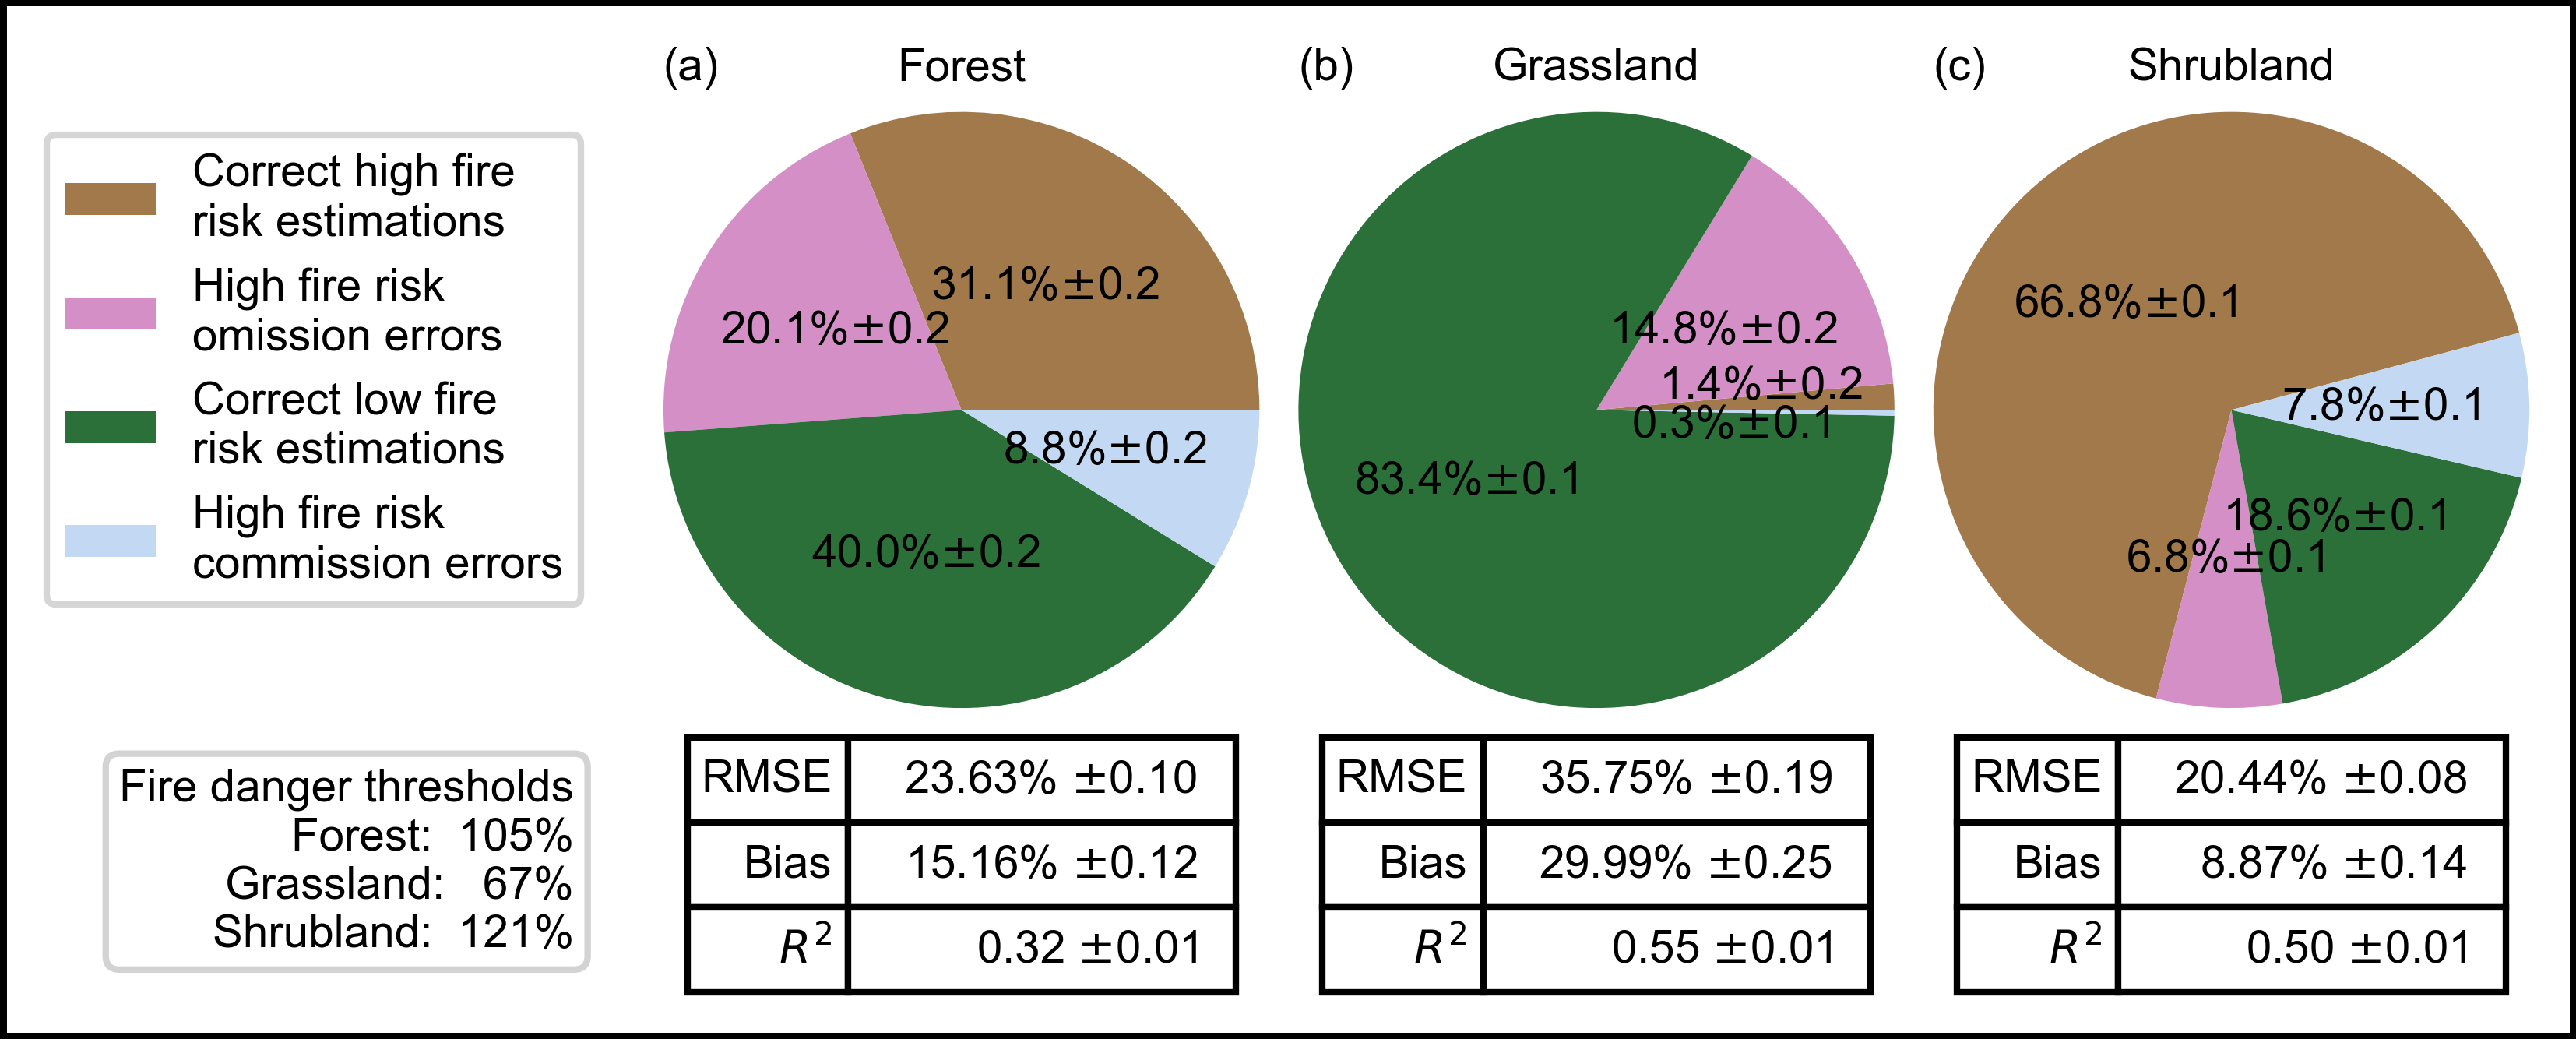

In [30]:
palette = sns.color_palette('cubehelix', 5)[1:]
colours = [palette[1], palette[2], palette[0], palette[3]]
sns.set_palette(colours)
labels = ['(a)', '(b)', '(c)']
pie_order = ['High fire risk', 'Warning failures', 'Low fire risk', 'False alarms']
# pie_labels = ['Correct high fire\nrisk estimations', 'Missed high fire\nrisk estimations',
#               'Correct low fire\nrisk estimations', 'False high fire\nrisk estimations']
pie_labels = ['Correct high fire\nrisk estimations', 'High fire risk\nomission errors',
              'Correct low fire\nrisk estimations', 'High fire risk\ncommission errors']
fig, ((ax1, ax2, ax3)) = plt.subplots(
    1, 3, figsize=(5.397, 4), sharey=False, sharex=False,  #7.346, 6.5      5.5, 4.5
    constrained_layout=True, dpi=600, linewidth=2, edgecolor="black")

plt.rcParams.update({'font.sans-serif': 'Arial'})
plt.rcParams.update({'font.size': TEXT_SIZE})

df1 = pd.concat([forest[0].T['mean'], grassland[0].T['mean'], shrubland[0].T['mean']], keys=lc_keys).unstack()
df1a = pd.concat([forest[1], grassland[1], shrubland[1]], axis=1, keys=lc_keys)
for idx, ax in enumerate([ax1, ax2, ax3]):
    lc_key = lc_keys[idx]
    sa = 15 if idx == 2 else 0
    df = plot_data['Projection Models'][lc_key][1]
    df1[pie_order].loc[lc_key].plot.pie(
        ax=ax, colors=colours, autopct=make_autopct(df),
        labels=['', '', '', ''], startangle=sa, pctdistance=0.5, radius=1)
    ax.set_ylabel('')
#    ax.set_xlabel(lc_key, fontsize=TEXT_SIZE)    
#    ax.xaxis.set_label_position('top')
    ax.set_title(lc_key, loc='center', size=TEXT_SIZE, pad=5)    
    ax.set_title(labels[idx], loc='left', size=TEXT_SIZE, pad=5)
    ax.set_xlim((-1.0,1.0))
    ax.set_ylim((-1.1,1.0))
    df_ = df1a[lc_key]
    values_ = [['RMSE', f"{df_[lc_key]['RMSE mean']:.2f}% $\pm${df_[lc_key]['RMSE std']:.2f}"],
               ['Bias', f"{df_[lc_key]['Bias mean']:.2f}% $\pm${df_[lc_key]['Bias std']:.2f}"],
               ['$R^2$', f"{df_[lc_key]['R2 mean']:.2f} $\pm${df_[lc_key]['R2 std']:.2f}"]]
    tab_ = ax.table(cellText=values_, loc='bottom', fontsize=TEXT_SIZE, colWidths=[0.27, 0.65])
    tab_.auto_set_font_size(False)

ax1.legend(labels=pie_labels, bbox_to_anchor=(-0.10, 1.0), fontsize=TEXT_SIZE)
ax1.text(-1.3, -1.2, "Fire danger thresholds\n" + "\n".join([f"{lc}: {th[2]:4d}%" for lc, th in counts.items()]),
         va='top', ha='right', bbox=dict(boxstyle='round,pad=0.3', facecolor='none', edgecolor='lightgrey'), size=TEXT_SIZE)

ax2.get_children()[2].set_position((0.55, 0.08))
ax2.get_children()[11].set_position((0.45, -0.05))

fig.savefig(os.path.join(common.FIGURES_DIR, 'LFMC thresholds.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.1, dpi=600)